<div style="font-weight: bold" align="center">
    <div style="font-size: xx-large; color:#3d6f91">Teoría de la Información</div><br>
    <div style="font-size: x-large; color:gray">Análisis spikes neuronales</div><br>
    <div style="font-size: large; color: #5D8AA8">Óscar Gómez Borzdynski y Alejandro Cabana Suárez</div><br></div><hr>
</div>

In [1]:
%%html
<style>
    h1, h2, h3 {color: #3d6f91;}
    b {color: #5D8AA8;}
</style>

# TODO:

* Calcular información mutua para todos los ficheros con resoluciones grandes <b style='color: green'>DONE</b>
* Función transferencia info, que es copiar la de informacion mutua y devolver dividiendo entre la entropia <b style='color: green'>DONE</b>
* Calcular información mutua para todos los ficheros utilizando los bursts como codificación <b style='color: green'>DONE</b>
* Gráficas interspike para explicar los thresholds en get_bursts y en la selección de resoluciones <b style='color: green'>DONE</b>
* Gráficas de una zona de los spikes para explicar los thresholds en get_spikes <b style='color: orange'>DOING</b>
* Gráficas de cada coso para ver cómo queda (Heatmaps, por tamaño de palabra...) <b style='color: green'>DONE</b>
* Comparar transferencia de información LP->VD frente a VD->LP 
* 16 gráficas de transferencia de información (una por tamaño de palabra) con 3 lineas donde cada una corresponden a un fichero <b style='color: green'>DONE</b>
* Shiftear una serie y medir la mi en función del retraso
* Ver cuántos spikes pillamos sin querer al ampliar la resolucion

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
import pickle
import seaborn as sns

# Análisis inicial
Comenzamos analizando los datos proporcionados por el profesor.

En primer lugar vemos la necesidad de encontrar los picos de cada una de las series temporales, para ello decidimos implementar la función `get_spikes()` que sigue el siguiente pseudo-código:

<hr>

```
crear una serie del mismo tamaño rellena de 0's

a lo largo de la serie:

    if ((serie supera threshold superior) y (no estamos ya dentro de un spike)) :
        marcar inicio spike
        
    if ((serie desciende de threshold inferior) y (estamos en un spike)) :
        marcar fin spike
        obtener el índice del máximo dentro del spike
        colocar un 1 en la serie para dicho índice
        
devolver la serie    
```

<hr>

Para definir los thresholds dibujamos el comienzo de las series. En las gráficas de debajo hemos colocado líneas horizontales en los thresholds escogidos.

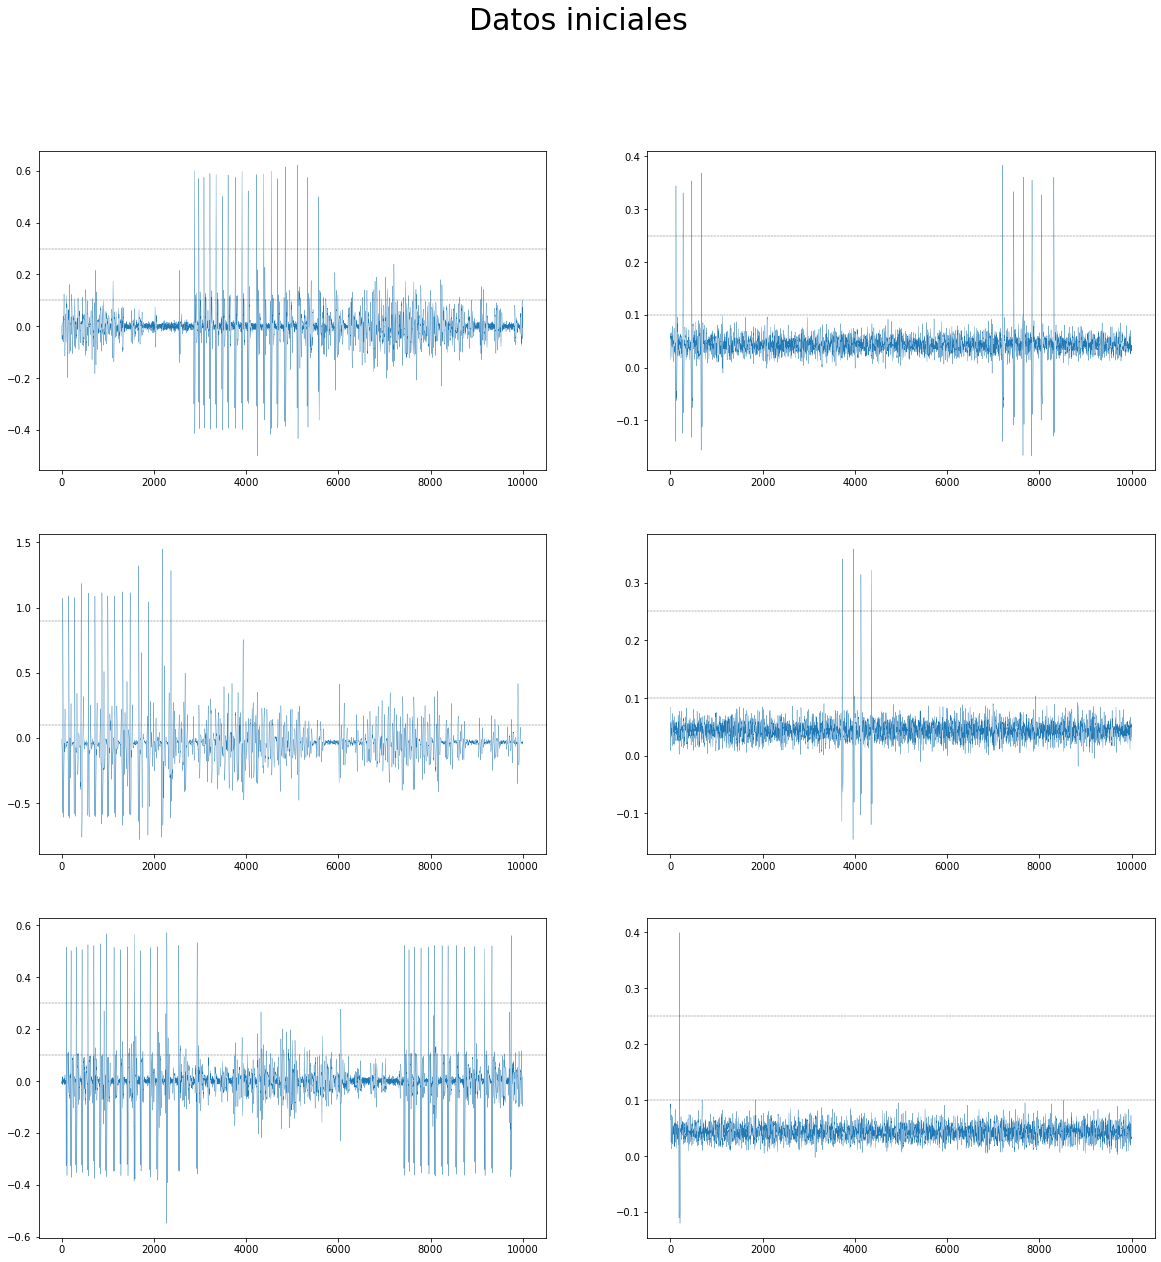

In [18]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoR.txt",
              "./DatosSinapsisArtificial/TrozoG.txt"]
cols = [["LP", "VD"],
        ["LP", "VD"],
        ["LP", "VD", "GABA"]]
thresholds = [{"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.9, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.3, 0.1], "VD": [0.25, 0.1]}]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Datos iniciales", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False).head(10000)
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.axhline(y=thresholds[i]["LP"][0], ls="-.", c='black', lw=0.3)
    plt.axhline(y=thresholds[i]["LP"][1], ls="-.", c='black', lw=0.3)
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.axhline(y=thresholds[i]["VD"][0], ls="-.", color='black', lw=0.3)
    plt.axhline(y=thresholds[i]["VD"][1], ls="-.", color='black', lw=0.3)

In [20]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoR.txt",
              "./DatosSinapsisArtificial/TrozoG.txt"]
cols = [["LP", "VD"],
        ["LP", "VD"],
        ["LP", "VD", "GABA"]]
thresholds = [{"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.9, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.3, 0.1], "VD": [0.25, 0.1]}]
to_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
            "./DatosSinapsisArtificial/TrozoR_bin.csv",
            "./DatosSinapsisArtificial/TrozoG_bin.csv"]

for i in [1]:#range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False)
    for col in thresholds[i].keys():
        get_spikes(df, col, t_ini=thresholds[i][col][0], t_fin=thresholds[i][col][0])
    df.to_csv(to_files[i])
    del df

# Spikes

En las gráficas siguientes vemos los puntos escogidos por la función `get_spikes()`, estos puntos están expresados por cruces en dichas posiciones.

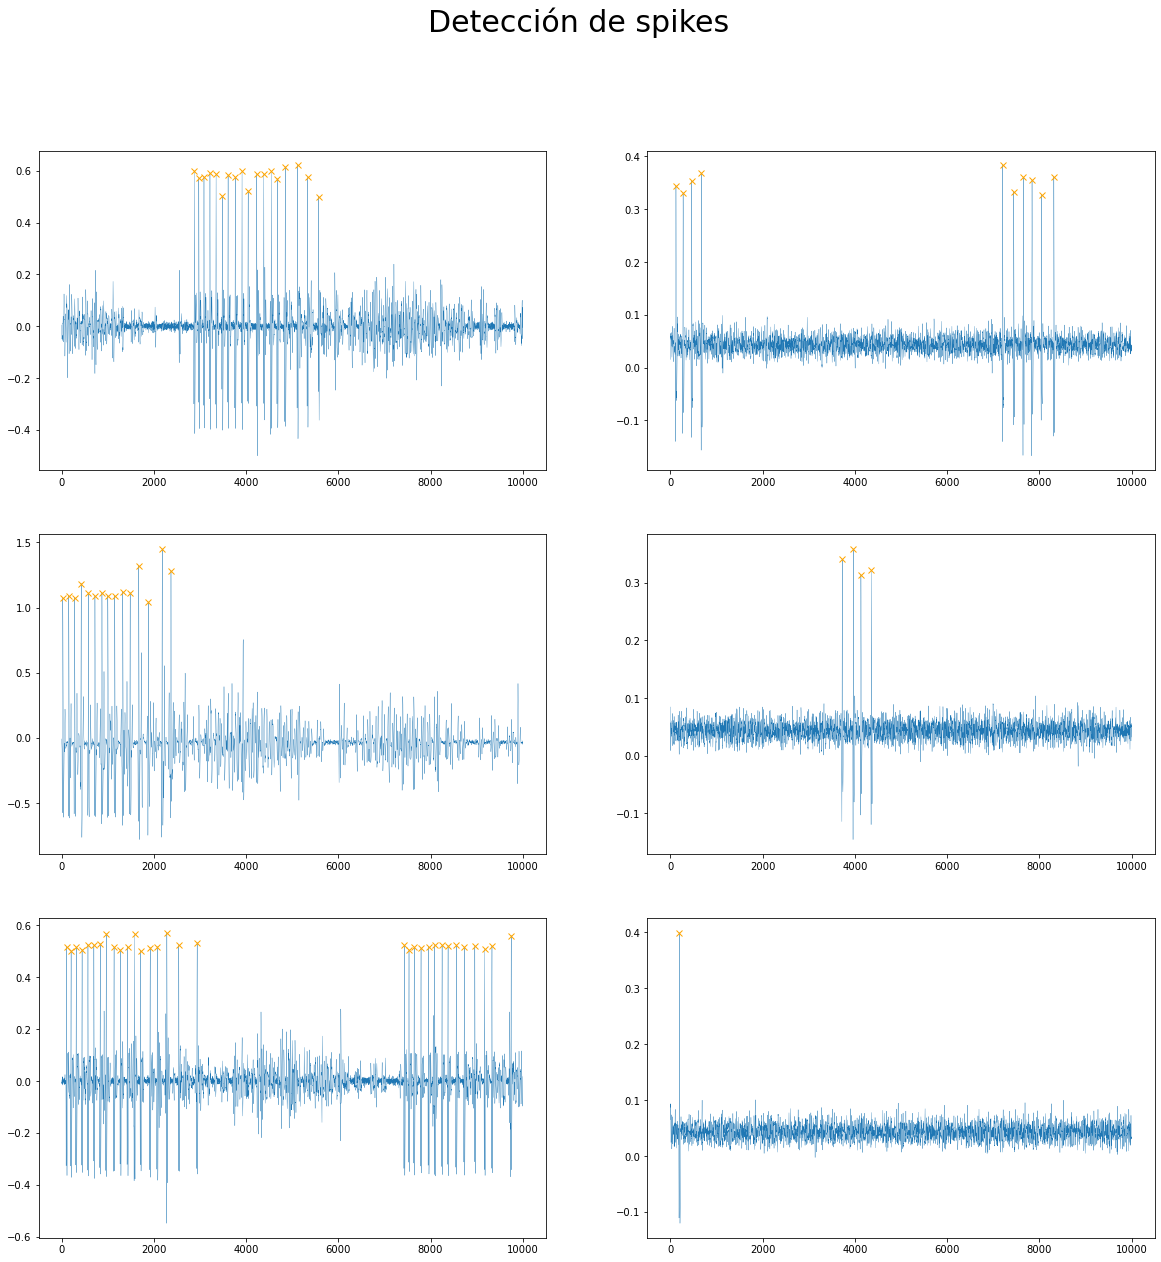

In [21]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoR.txt",
              "./DatosSinapsisArtificial/TrozoG.txt"]
bin_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
             "./DatosSinapsisArtificial/TrozoR_bin.csv",
             "./DatosSinapsisArtificial/TrozoG_bin.csv"]
cols = [["LP", "VD"],
        ["LP", "VD"],
        ["LP", "VD", "GABA"]]
thresholds = [{"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.9, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.3, 0.1], "VD": [0.25, 0.1]}]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Detección de spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False, nrows=10000)
    df2 = pd.read_csv(bin_files[i],nrows=10000)
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.plot(df2[df2["LP_bin"] == 1]["LP"], 'x', c='orange')
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.plot(df2[df2["VD_bin"] == 1]["VD"], 'x', c='orange')

# Distancia entre spikes

En esta práctica debemos calcular:

* Entropía
* Información mutua
* Entropía normalizada

Para todos estos cálculos debemos decidir 2 parámetros, el tamaño de bin, al que hemos llamado resolución y el tamaño de palabra (cuántos bins se analizan simultáneamente). En todos los casos hemos decidido tomar un tamaño de palabra máximo de 8 bins. 

Para decidir la resolución obtenemos un histograma de la distancia entre dos spikes seguidos. Hemos colocado una barra vertical en la resolución máxima que calcularemos. Hemos escogido este límite pese a que en algunos casos introducimos dos spikes en un solo bin. Dado que calcularemos todas las resoluciones entre 1 y ese límite podremos analizar qué implica seleccionar un tamaño de bin demasiado grande.

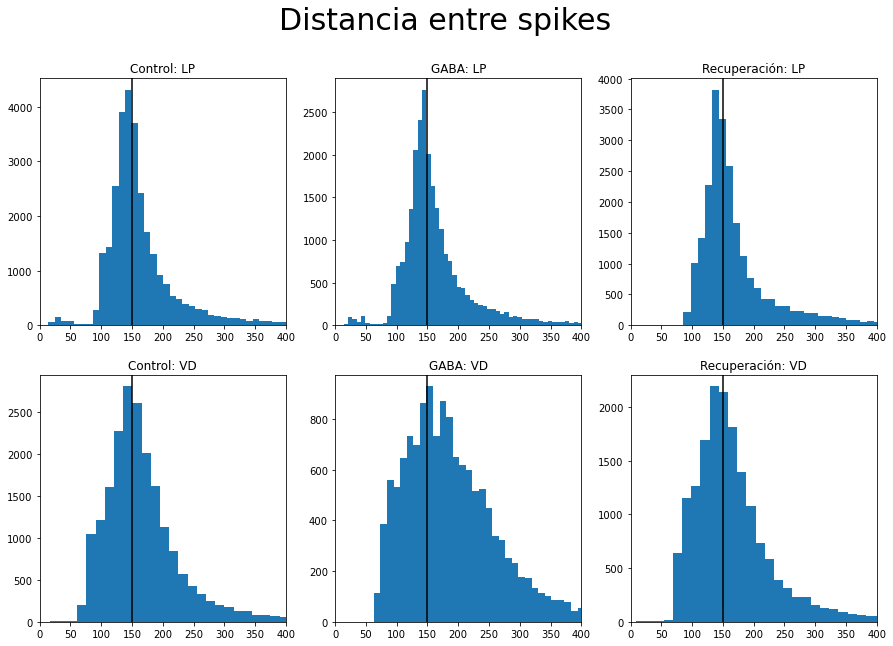

In [22]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

    w = df.index[df.LP_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: LP")
    
    w = df.index[df.VD_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: VD")

Podemos ver que en la mayoría de los casos el punto que deberíamos seleccionar para dejar fuera solo los errores es de una resolución de aproximadamente 60, pero llegando al máximo del histograma esperamos escoger la distancia mas habitual.

Para modificar la resolución de las series obtenidas previamente definimos la función `resolution()` que sigue el siguiente pseudocódigo:

<hr>

```
dividir la serie en fragmentos de tamaño máximo igual a la resolución

para cada fragmento:
    si no existe ningún spike en la serie original -> 0
    si existe algún spike en la serie original -> 1
    
reagrupar todos los fragmentos en una serie de tamaño techo(tamaño original/resolución)
```

<hr>

Luego para calcular las métricas definimos la función `transfer_info()` que sigue el siguiente pseudocódigo:

<hr>

```
dividir la serie en ventanas solapadas de tamaño longitud de la palabra

para cada ventana:
    obtener el número que se obtiene al transformar de binario a decimal
    combinar ambos números para la entropía conjunta 
    
obtener las probabilidades de aparición de cada número

calcular las entropías de cada columna
calcular la entropía conjunta
calcular la información mutua como la suma de las entropías individuales menos la conjunta
calcular las entropías normalizadas

devolver todos los cálculos realizados
```

<hr>

Guardamos todos los cálculos realizados en ficheros específicos para cada fragmento de datos.


In [23]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv"]
cols = [["LP_bin", "VD_bin"],
        ["LP_bin", "VD_bin"],
        ["LP_bin", "VD_bin"]]
to_files = ["dataC.pkl",
            "dataR.pkl",
            "dataG.pkl"]
resolutions = [150, 150, 150]
word_lens = [8, 8, 8]
col_names = [f"word_len {i+1}" for i in range(max(word_lens))]
row_names = [f"resolution {i+1}" for i in range(max(resolutions))]
for n in [1]: #range(len(from_files)):
    df = pd.read_csv(from_files[n])[cols[n]]
    df = df.astype({cols[n][0]:'u1', cols[n][0]:'u1'})
    try:
        with open(to_files[n], "rb") as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = {
            "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
            "transfer_info_col2_col1" : pd.DataFrame(columns = col_names, index = row_names),
            "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
            "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
        }
        data["transfer_info_col1_col2"][:] = 0
        data["transfer_info_col2_col1"][:] = 0
        data["mutual_info"][:] = 0
        data["col1_entropy"][:] = 0
        data["col2_entropy"][:] = 0
        data["joined_entropy"][:] = 0
    for i in range(resolutions[n]):
        for j in range(word_lens[n]):
            if (data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] != 0 and
                data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] != 0 and
                data["mutual_info"].loc[row_names[i], col_names[j]] != 0 and
                data["col1_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["col2_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["joined_entropy"].loc[row_names[i], col_names[j]] != 0):
                print(f"Previamente calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
                continue
            print(f"Comienzo cálculo resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            tr, mi, e, ej = transfer_info(resolution(df, i+1), cols[n], j+1)
            data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] = tr[0]
            data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] = tr[1]
            data["mutual_info"].loc[row_names[i], col_names[j]] = mi
            data["col1_entropy"].loc[row_names[i], col_names[j]] = e[0]
            data["col2_entropy"].loc[row_names[i], col_names[j]] = e[1]
            data["joined_entropy"].loc[row_names[i], col_names[j]] = ej
            print(f"Calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            with open(to_files[n], "wb") as f:
                pickle.dump(data, f)

Previamente calculado dataR.pkl: resolución=1, palabra=1 en la posicion[0][0]
Previamente calculado dataR.pkl: resolución=1, palabra=2 en la posicion[0][1]
Previamente calculado dataR.pkl: resolución=1, palabra=3 en la posicion[0][2]
Previamente calculado dataR.pkl: resolución=1, palabra=4 en la posicion[0][3]
Previamente calculado dataR.pkl: resolución=1, palabra=5 en la posicion[0][4]
Previamente calculado dataR.pkl: resolución=1, palabra=6 en la posicion[0][5]
Previamente calculado dataR.pkl: resolución=1, palabra=7 en la posicion[0][6]
Previamente calculado dataR.pkl: resolución=1, palabra=8 en la posicion[0][7]
Previamente calculado dataR.pkl: resolución=2, palabra=1 en la posicion[1][0]
Previamente calculado dataR.pkl: resolución=2, palabra=2 en la posicion[1][1]
Previamente calculado dataR.pkl: resolución=2, palabra=3 en la posicion[1][2]
Previamente calculado dataR.pkl: resolución=2, palabra=4 en la posicion[1][3]
Previamente calculado dataR.pkl: resolución=2, palabra=5 en la p

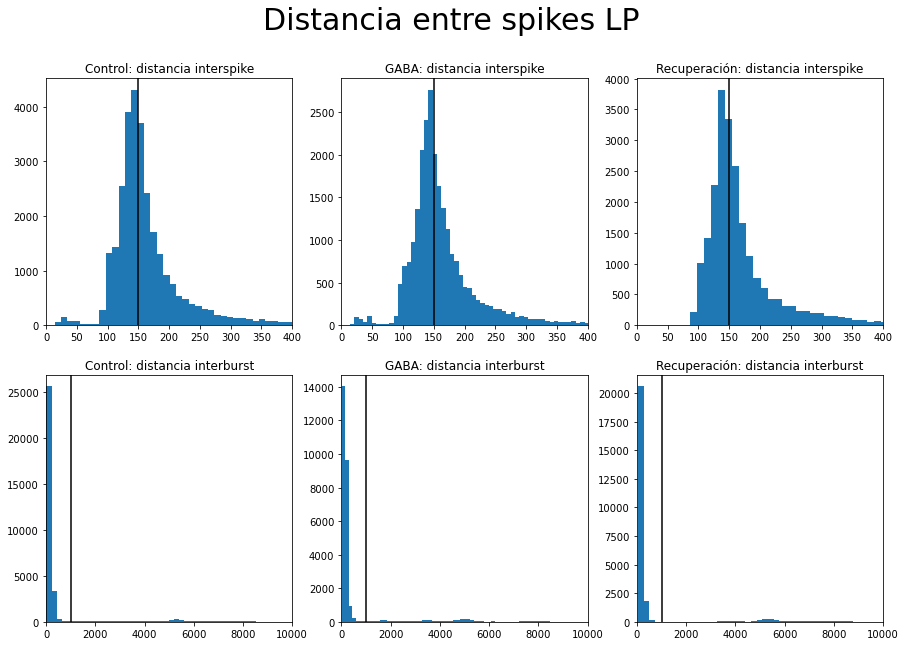

In [26]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre spikes LP", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin'])
    df = df.astype({"LP_bin":'u1'})

    w = df.index[df.LP_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: distancia interspike")
    
    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=100)
    plt.axvline(x=1000, color='k')
    plt.xlim((0, 10000))
    plt.title(f"{titles[i]}: distancia interburst")

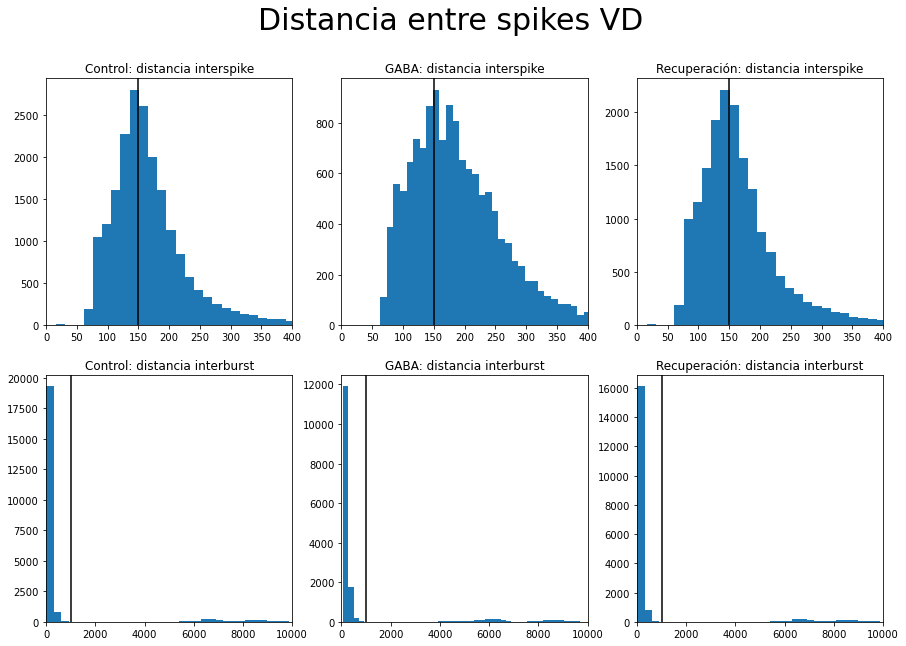

In [13]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre spikes VD", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], uscomo laecols=['VD_bin'])
    df = df.astype({"VD_bin":'u1'})

    w = df.index[df.VD_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: distancia interspike")
    
    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=100)
    plt.axvline(x=1000, color='k')
    plt.xlim((0, 10000))
    plt.title(f"{titles[i]}: distancia interburst")

In [24]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv"]
cols = [["LP_burst", "VD_burst"],
        ["LP_burst", "VD_burst"],
        ["LP_burst", "VD_burst"]]
bin_cols = [["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"]]
to_files = ["dataC_burst.pkl",
            "dataR_burst.pkl",
            "dataG_burst.pkl"]
thresholds = [1000,1000,1000]
resolutions = [2000, 2000, 2000]
word_lens = [8, 8, 8]
col_names = [f"word_len {i+1}" for i in range(max(word_lens))]
row_names = [f"resolution {i+1}" for i in range(max(resolutions))]
for n in [1]: #range(len(from_files)):
    df = pd.read_csv(from_files[n])[bin_cols[n]]
    df = get_bursts(df, thresholds[n], bin_cols[n], cols[n])[cols[n]]
    df = df.astype({cols[n][0]:'u1', cols[n][0]:'u1'})
    try:
        with open(to_files[n], "rb") as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = {
            "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
            "transfer_info_col2_col1" : pd.DataFrame(columns = col_names, index = row_names),
            "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
            "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
        }
        data["transfer_info_col1_col2"][:] = 0
        data["transfer_info_col2_col1"][:] = 0
        data["mutual_info"][:] = 0
        data["col1_entropy"][:] = 0
        data["col2_entropy"][:] = 0
        data["joined_entropy"][:] = 0
    for i in range(resolutions[n]):
        for j in range(word_lens[n]):
            if (data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] != 0 and
                data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] != 0 and
                data["mutual_info"].loc[row_names[i], col_names[j]] != 0 and
                data["col1_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["col2_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["joined_entropy"].loc[row_names[i], col_names[j]] != 0):
                print(f"Previamente calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
                continue
            print(f"Comienzo cálculo resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            tr, mi, e, ej = transfer_info(resolution(df, i+1), cols[n], j+1)
            data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] = tr[0]
            data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] = tr[1]
            data["mutual_info"].loc[row_names[i], col_names[j]] = mi
            data["col1_entropy"].loc[row_names[i], col_names[j]] = e[0]
            data["col2_entropy"].loc[row_names[i], col_names[j]] = e[1]
            data["joined_entropy"].loc[row_names[i], col_names[j]] = ej
            print(f"Calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            with open(to_files[n], "wb") as f:
                pickle.dump(data, f)

Previamente calculado dataR_burst.pkl: resolución=1, palabra=1 en la posicion[0][0]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=2 en la posicion[0][1]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=3 en la posicion[0][2]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=4 en la posicion[0][3]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=5 en la posicion[0][4]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=6 en la posicion[0][5]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=7 en la posicion[0][6]
Previamente calculado dataR_burst.pkl: resolución=1, palabra=8 en la posicion[0][7]
Previamente calculado dataR_burst.pkl: resolución=2, palabra=1 en la posicion[1][0]
Previamente calculado dataR_burst.pkl: resolución=2, palabra=2 en la posicion[1][1]
Previamente calculado dataR_burst.pkl: resolución=2, palabra=3 en la posicion[1][2]
Previamente calculado dataR_burst.pkl: resolución=2, palabra=4 en la posicio

Previamente calculado dataR_burst.pkl: resolución=202, palabra=2 en la posicion[201][1]
Previamente calculado dataR_burst.pkl: resolución=202, palabra=3 en la posicion[201][2]
Previamente calculado dataR_burst.pkl: resolución=202, palabra=4 en la posicion[201][3]
Previamente calculado dataR_burst.pkl: resolución=202, palabra=5 en la posicion[201][4]
Previamente calculado dataR_burst.pkl: resolución=202, palabra=6 en la posicion[201][5]
Previamente calculado dataR_burst.pkl: resolución=202, palabra=7 en la posicion[201][6]
Previamente calculado dataR_burst.pkl: resolución=202, palabra=8 en la posicion[201][7]
Previamente calculado dataR_burst.pkl: resolución=203, palabra=1 en la posicion[202][0]
Previamente calculado dataR_burst.pkl: resolución=203, palabra=2 en la posicion[202][1]
Previamente calculado dataR_burst.pkl: resolución=203, palabra=3 en la posicion[202][2]
Previamente calculado dataR_burst.pkl: resolución=203, palabra=4 en la posicion[202][3]
Previamente calculado dataR_burs

Previamente calculado dataR_burst.pkl: resolución=348, palabra=2 en la posicion[347][1]
Previamente calculado dataR_burst.pkl: resolución=348, palabra=3 en la posicion[347][2]
Previamente calculado dataR_burst.pkl: resolución=348, palabra=4 en la posicion[347][3]
Previamente calculado dataR_burst.pkl: resolución=348, palabra=5 en la posicion[347][4]
Previamente calculado dataR_burst.pkl: resolución=348, palabra=6 en la posicion[347][5]
Previamente calculado dataR_burst.pkl: resolución=348, palabra=7 en la posicion[347][6]
Previamente calculado dataR_burst.pkl: resolución=348, palabra=8 en la posicion[347][7]
Previamente calculado dataR_burst.pkl: resolución=349, palabra=1 en la posicion[348][0]
Previamente calculado dataR_burst.pkl: resolución=349, palabra=2 en la posicion[348][1]
Previamente calculado dataR_burst.pkl: resolución=349, palabra=3 en la posicion[348][2]
Previamente calculado dataR_burst.pkl: resolución=349, palabra=4 en la posicion[348][3]
Previamente calculado dataR_burs

Previamente calculado dataR_burst.pkl: resolución=497, palabra=4 en la posicion[496][3]
Previamente calculado dataR_burst.pkl: resolución=497, palabra=5 en la posicion[496][4]
Previamente calculado dataR_burst.pkl: resolución=497, palabra=6 en la posicion[496][5]
Previamente calculado dataR_burst.pkl: resolución=497, palabra=7 en la posicion[496][6]
Previamente calculado dataR_burst.pkl: resolución=497, palabra=8 en la posicion[496][7]
Previamente calculado dataR_burst.pkl: resolución=498, palabra=1 en la posicion[497][0]
Previamente calculado dataR_burst.pkl: resolución=498, palabra=2 en la posicion[497][1]
Previamente calculado dataR_burst.pkl: resolución=498, palabra=3 en la posicion[497][2]
Previamente calculado dataR_burst.pkl: resolución=498, palabra=4 en la posicion[497][3]
Previamente calculado dataR_burst.pkl: resolución=498, palabra=5 en la posicion[497][4]
Previamente calculado dataR_burst.pkl: resolución=498, palabra=6 en la posicion[497][5]
Previamente calculado dataR_burs

Previamente calculado dataR_burst.pkl: resolución=639, palabra=3 en la posicion[638][2]
Previamente calculado dataR_burst.pkl: resolución=639, palabra=4 en la posicion[638][3]
Previamente calculado dataR_burst.pkl: resolución=639, palabra=5 en la posicion[638][4]
Previamente calculado dataR_burst.pkl: resolución=639, palabra=6 en la posicion[638][5]
Previamente calculado dataR_burst.pkl: resolución=639, palabra=7 en la posicion[638][6]
Previamente calculado dataR_burst.pkl: resolución=639, palabra=8 en la posicion[638][7]
Previamente calculado dataR_burst.pkl: resolución=640, palabra=1 en la posicion[639][0]
Previamente calculado dataR_burst.pkl: resolución=640, palabra=2 en la posicion[639][1]
Previamente calculado dataR_burst.pkl: resolución=640, palabra=3 en la posicion[639][2]
Previamente calculado dataR_burst.pkl: resolución=640, palabra=4 en la posicion[639][3]
Previamente calculado dataR_burst.pkl: resolución=640, palabra=5 en la posicion[639][4]
Previamente calculado dataR_burs

Previamente calculado dataR_burst.pkl: resolución=768, palabra=2 en la posicion[767][1]
Previamente calculado dataR_burst.pkl: resolución=768, palabra=3 en la posicion[767][2]
Previamente calculado dataR_burst.pkl: resolución=768, palabra=4 en la posicion[767][3]
Previamente calculado dataR_burst.pkl: resolución=768, palabra=5 en la posicion[767][4]
Previamente calculado dataR_burst.pkl: resolución=768, palabra=6 en la posicion[767][5]
Previamente calculado dataR_burst.pkl: resolución=768, palabra=7 en la posicion[767][6]
Previamente calculado dataR_burst.pkl: resolución=768, palabra=8 en la posicion[767][7]
Previamente calculado dataR_burst.pkl: resolución=769, palabra=1 en la posicion[768][0]
Previamente calculado dataR_burst.pkl: resolución=769, palabra=2 en la posicion[768][1]
Previamente calculado dataR_burst.pkl: resolución=769, palabra=3 en la posicion[768][2]
Previamente calculado dataR_burst.pkl: resolución=769, palabra=4 en la posicion[768][3]
Previamente calculado dataR_burs

Previamente calculado dataR_burst.pkl: resolución=909, palabra=5 en la posicion[908][4]
Previamente calculado dataR_burst.pkl: resolución=909, palabra=6 en la posicion[908][5]
Previamente calculado dataR_burst.pkl: resolución=909, palabra=7 en la posicion[908][6]
Previamente calculado dataR_burst.pkl: resolución=909, palabra=8 en la posicion[908][7]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=1 en la posicion[909][0]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=2 en la posicion[909][1]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=3 en la posicion[909][2]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=4 en la posicion[909][3]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=5 en la posicion[909][4]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=6 en la posicion[909][5]
Previamente calculado dataR_burst.pkl: resolución=910, palabra=7 en la posicion[909][6]
Previamente calculado dataR_burs

Previamente calculado dataR_burst.pkl: resolución=1064, palabra=8 en la posicion[1063][7]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=1 en la posicion[1064][0]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=2 en la posicion[1064][1]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=3 en la posicion[1064][2]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=4 en la posicion[1064][3]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=5 en la posicion[1064][4]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=6 en la posicion[1064][5]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=7 en la posicion[1064][6]
Previamente calculado dataR_burst.pkl: resolución=1065, palabra=8 en la posicion[1064][7]
Previamente calculado dataR_burst.pkl: resolución=1066, palabra=1 en la posicion[1065][0]
Previamente calculado dataR_burst.pkl: resolución=1066, palabra=2 en la posicion[1065][1]
Previament

Previamente calculado dataR_burst.pkl: resolución=1182, palabra=6 en la posicion[1181][5]
Previamente calculado dataR_burst.pkl: resolución=1182, palabra=7 en la posicion[1181][6]
Previamente calculado dataR_burst.pkl: resolución=1182, palabra=8 en la posicion[1181][7]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=1 en la posicion[1182][0]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=2 en la posicion[1182][1]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=3 en la posicion[1182][2]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=4 en la posicion[1182][3]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=5 en la posicion[1182][4]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=6 en la posicion[1182][5]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=7 en la posicion[1182][6]
Previamente calculado dataR_burst.pkl: resolución=1183, palabra=8 en la posicion[1182][7]
Previament

Previamente calculado dataR_burst.pkl: resolución=1332, palabra=1 en la posicion[1331][0]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=2 en la posicion[1331][1]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=3 en la posicion[1331][2]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=4 en la posicion[1331][3]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=5 en la posicion[1331][4]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=6 en la posicion[1331][5]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=7 en la posicion[1331][6]
Previamente calculado dataR_burst.pkl: resolución=1332, palabra=8 en la posicion[1331][7]
Previamente calculado dataR_burst.pkl: resolución=1333, palabra=1 en la posicion[1332][0]
Previamente calculado dataR_burst.pkl: resolución=1333, palabra=2 en la posicion[1332][1]
Previamente calculado dataR_burst.pkl: resolución=1333, palabra=3 en la posicion[1332][2]
Previament

Previamente calculado dataR_burst.pkl: resolución=1466, palabra=8 en la posicion[1465][7]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=1 en la posicion[1466][0]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=2 en la posicion[1466][1]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=3 en la posicion[1466][2]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=4 en la posicion[1466][3]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=5 en la posicion[1466][4]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=6 en la posicion[1466][5]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=7 en la posicion[1466][6]
Previamente calculado dataR_burst.pkl: resolución=1467, palabra=8 en la posicion[1466][7]
Previamente calculado dataR_burst.pkl: resolución=1468, palabra=1 en la posicion[1467][0]
Previamente calculado dataR_burst.pkl: resolución=1468, palabra=2 en la posicion[1467][1]
Previament

Previamente calculado dataR_burst.pkl: resolución=1600, palabra=2 en la posicion[1599][1]
Previamente calculado dataR_burst.pkl: resolución=1600, palabra=3 en la posicion[1599][2]
Previamente calculado dataR_burst.pkl: resolución=1600, palabra=4 en la posicion[1599][3]
Previamente calculado dataR_burst.pkl: resolución=1600, palabra=5 en la posicion[1599][4]
Previamente calculado dataR_burst.pkl: resolución=1600, palabra=6 en la posicion[1599][5]
Previamente calculado dataR_burst.pkl: resolución=1600, palabra=7 en la posicion[1599][6]
Previamente calculado dataR_burst.pkl: resolución=1600, palabra=8 en la posicion[1599][7]
Previamente calculado dataR_burst.pkl: resolución=1601, palabra=1 en la posicion[1600][0]
Previamente calculado dataR_burst.pkl: resolución=1601, palabra=2 en la posicion[1600][1]
Previamente calculado dataR_burst.pkl: resolución=1601, palabra=3 en la posicion[1600][2]
Previamente calculado dataR_burst.pkl: resolución=1601, palabra=4 en la posicion[1600][3]
Previament

Previamente calculado dataR_burst.pkl: resolución=1767, palabra=3 en la posicion[1766][2]
Previamente calculado dataR_burst.pkl: resolución=1767, palabra=4 en la posicion[1766][3]
Previamente calculado dataR_burst.pkl: resolución=1767, palabra=5 en la posicion[1766][4]
Previamente calculado dataR_burst.pkl: resolución=1767, palabra=6 en la posicion[1766][5]
Previamente calculado dataR_burst.pkl: resolución=1767, palabra=7 en la posicion[1766][6]
Previamente calculado dataR_burst.pkl: resolución=1767, palabra=8 en la posicion[1766][7]
Previamente calculado dataR_burst.pkl: resolución=1768, palabra=1 en la posicion[1767][0]
Previamente calculado dataR_burst.pkl: resolución=1768, palabra=2 en la posicion[1767][1]
Previamente calculado dataR_burst.pkl: resolución=1768, palabra=3 en la posicion[1767][2]
Previamente calculado dataR_burst.pkl: resolución=1768, palabra=4 en la posicion[1767][3]
Previamente calculado dataR_burst.pkl: resolución=1768, palabra=5 en la posicion[1767][4]
Previament

Previamente calculado dataR_burst.pkl: resolución=1890, palabra=5 en la posicion[1889][4]
Previamente calculado dataR_burst.pkl: resolución=1890, palabra=6 en la posicion[1889][5]
Previamente calculado dataR_burst.pkl: resolución=1890, palabra=7 en la posicion[1889][6]
Previamente calculado dataR_burst.pkl: resolución=1890, palabra=8 en la posicion[1889][7]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=1 en la posicion[1890][0]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=2 en la posicion[1890][1]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=3 en la posicion[1890][2]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=4 en la posicion[1890][3]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=5 en la posicion[1890][4]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=6 en la posicion[1890][5]
Previamente calculado dataR_burst.pkl: resolución=1891, palabra=7 en la posicion[1890][6]
Previament

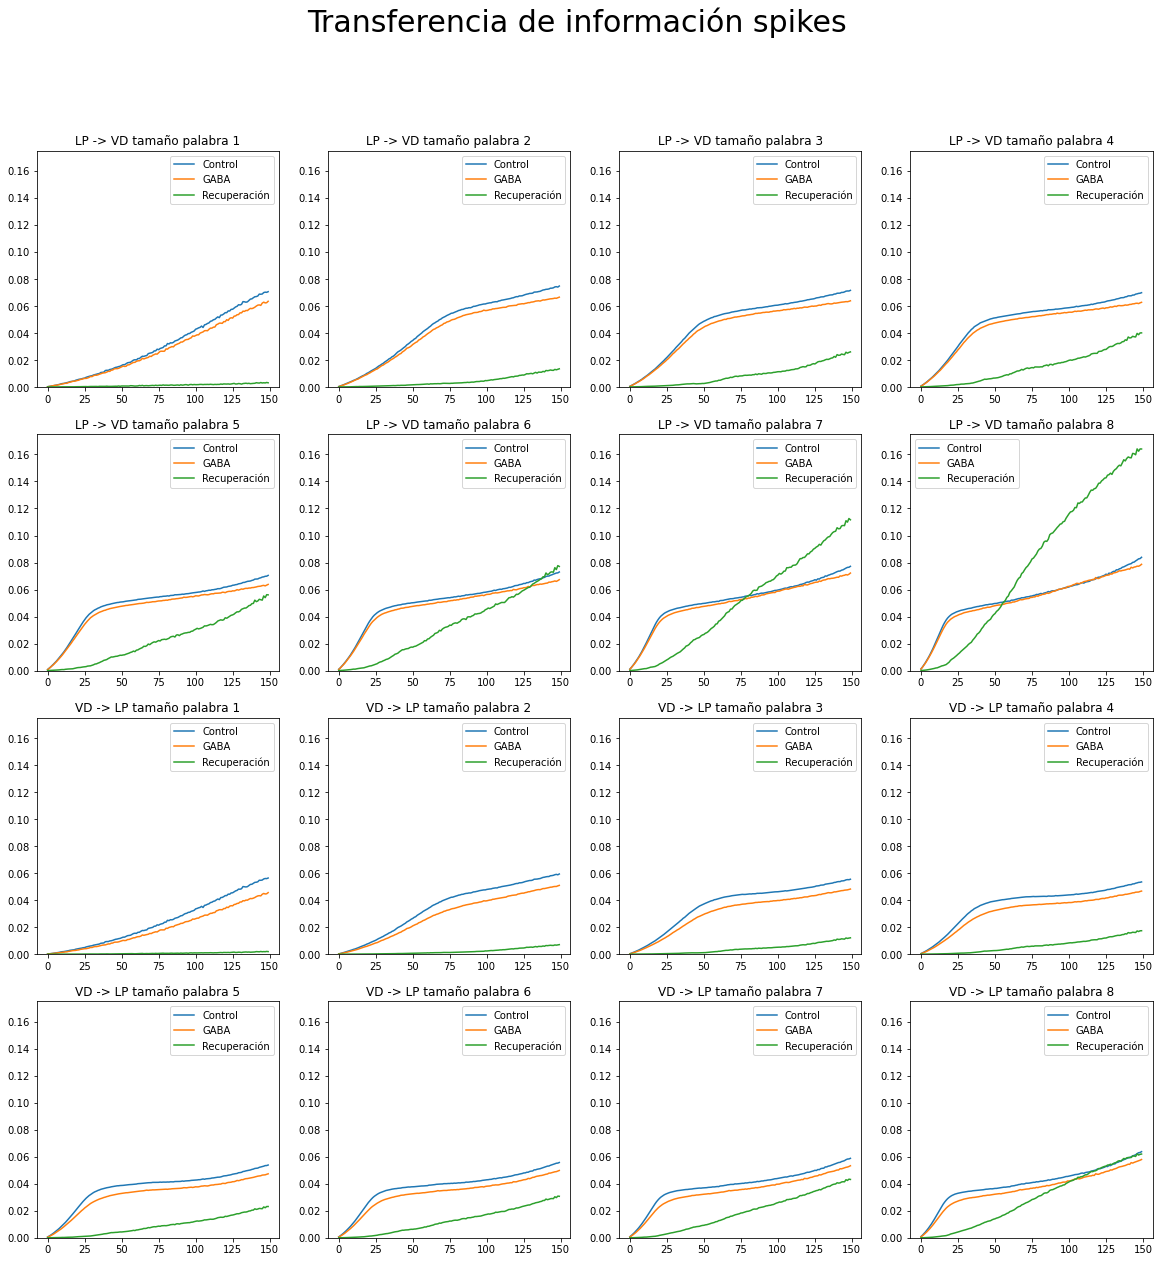

In [27]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Transferencia de información spikes", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col1_col2"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col1_col2"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.ylim((0,0.175))
    plt.title(f"LP -> VD tamaño palabra {w}")
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col2_col1"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col2_col1"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD -> LP tamaño palabra {w}")
    plt.ylim((0,0.175))
    plt.legend()

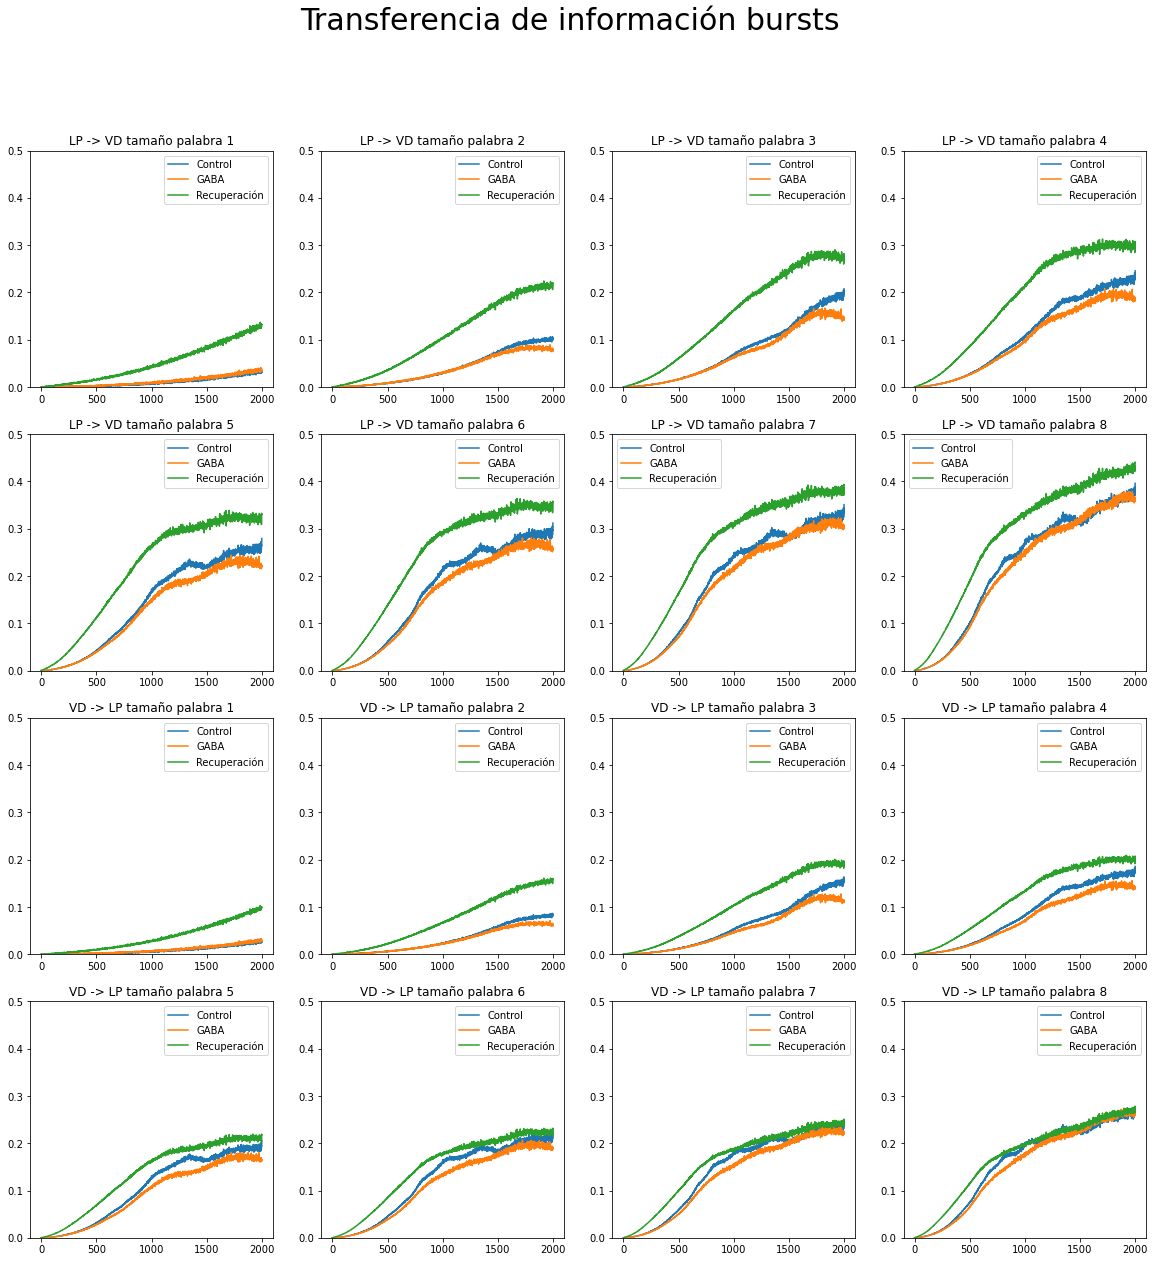

In [28]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Transferencia de información bursts", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col1_col2"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col1_col2"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"LP -> VD tamaño palabra {w}")
    plt.ylim((0,0.5))
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col2_col1"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col2_col1"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD -> LP tamaño palabra {w}")
    plt.ylim((0,0.5))
    plt.legend()

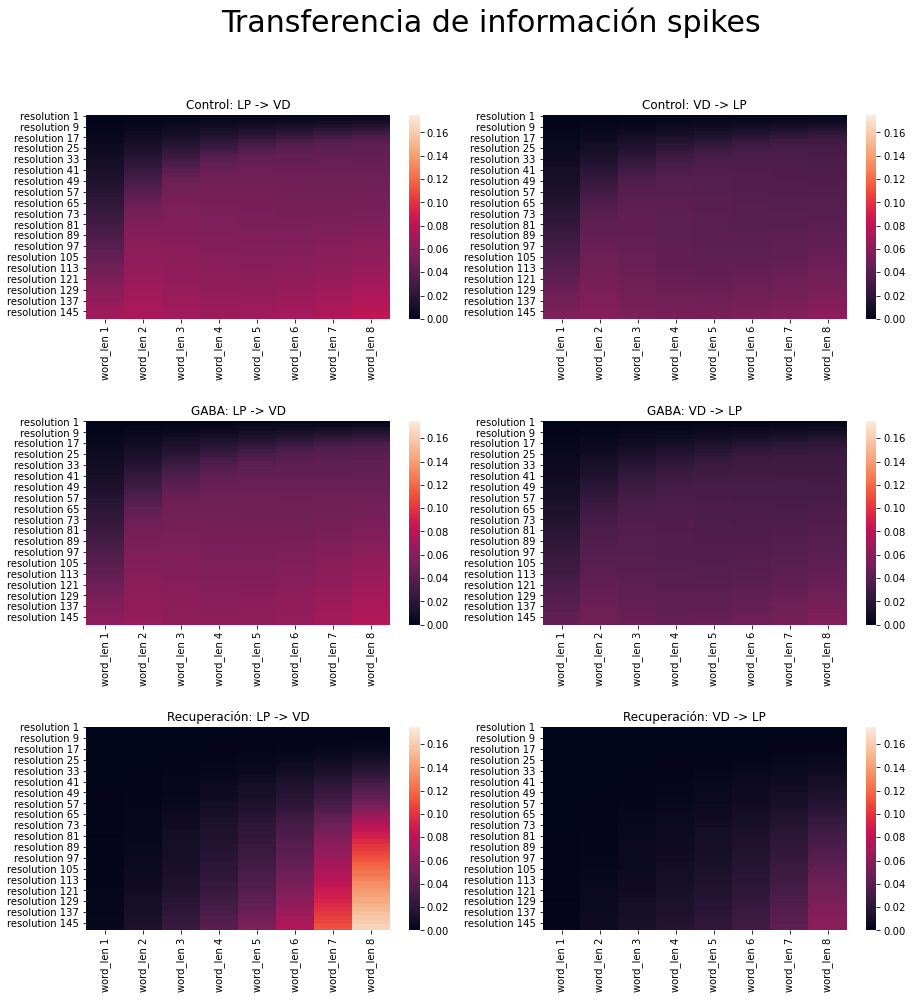

In [31]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Transferencia de información spikes", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.175)
    plt.title(f"{labels[i]}: LP -> VD")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.175)
    plt.title(f"{labels[i]}: VD -> LP")

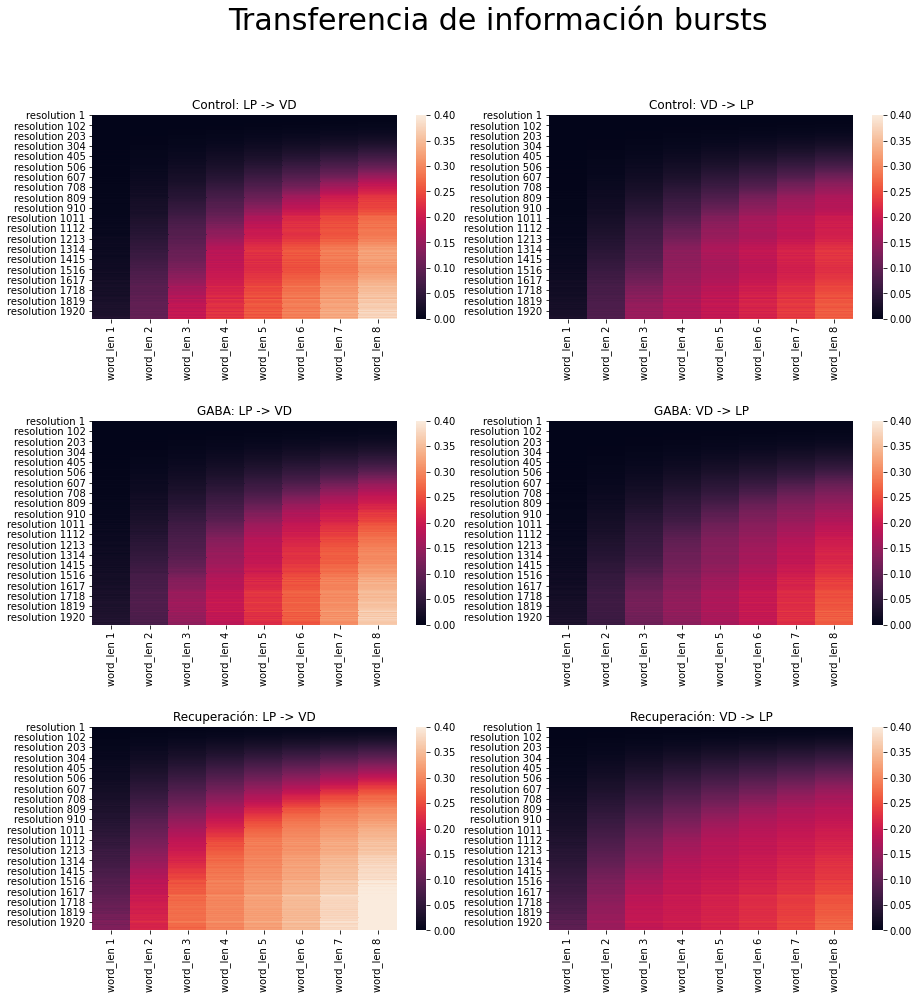

In [30]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Transferencia de información bursts", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.4)
    plt.title(f"{labels[i]}: LP -> VD")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.4)
    plt.title(f"{labels[i]}: VD -> LP")

In [15]:
with open("dataR.pkl", "rb") as f:
    data = pickle.load(f)

In [16]:
data

AttributeError: 'DataFrame' object has no attribute '_data'

In [47]:
with open("dataC_burst.pkl", "rb") as f:
    data = pickle.load(f)

In [18]:
data["mutual_info"]

AttributeError: 'DataFrame' object has no attribute '_data'

In [38]:
data[0]

KeyError: 0

<AxesSubplot:>

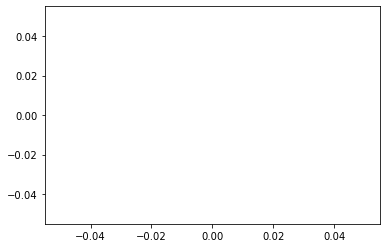

In [28]:
sns.lineplot(np.array(data["mutual_info"]['word_len 2'].convert_dtypes()))

In [33]:
data["mutual_info"].reset_index(drop=True)

,word_len 0,word_len 1,word_len 2,word_len 3,word_len 4,word_len 5,word_len 6,word_len 7
0,2.06148e-06,7.40958e-06,1.77114e-05,3.19026e-05,4.95543e-05,7.14557e-05,9.68727e-05,0.000126173
1,7.85429e-06,3.1142e-05,6.96614e-05,0.000122853,0.000189816,0.000270844,0.000368106,0.000479322
2,1.74121e-05,6.94287e-05,0.000156612,0.000272132,0.000422659,0.000608749,0.000830879,0.00108551
3,3.07528e-05,0.000123814,0.000273134,0.000480229,0.000750985,0.00108671,0.00148332,0.00194133
4,4.69738e-05,0.000194359,0.000425165,0.000753399,0.00118065,0.00170851,0.00234039,0.00307648
...,...,...,...,...,...,...,...,...
145,0.0420932,0.0736974,0.0911916,0.108371,0.128363,0.151678,0.179606,0.214611
146,0.0428507,0.0742137,0.0918878,0.108704,0.128713,0.152595,0.181302,0.216874
147,0.0431704,0.074545,0.0921916,0.109358,0.129599,0.153585,0.182558,0.218935
148,0.0431936,0.0741034,0.0920293,0.109456,0.129682,0.15381,0.1829,0.219677


In [25]:
np.array(data["mutual_info"]['word_len 2'])

array([1.7711440774462184e-05, 6.966143159303773e-05,
       0.00015661216080709028, 0.000273134128193131,
       0.0004251645030886042, 0.0006101233761254266,
       0.0008252209328684645, 0.0010827267491336778,
       0.0013600679525426207, 0.0017134037974101402,
       0.0020674200247243757, 0.002445707844482725, 0.002891716840246472,
       0.003374628383813305, 0.00391592701339849, 0.004482139156230969,
       0.005042061302884315, 0.00563856459173917, 0.006345118729211396,
       0.007106595114675152, 0.007867823735966395, 0.008632088657994252,
       0.009548437258996678, 0.010400801483772426, 0.011380537498129062,
       0.012323557204047653, 0.013395000838961613, 0.01451313386948061,
       0.015577969051745688, 0.016734771681222504, 0.017892613254598677,
       0.019233638532944353, 0.020484179997506846, 0.0216970120420783,
       0.023090429982270066, 0.024359890396790984, 0.02591919733569914,
       0.02713640467984324, 0.02860869503289387, 0.03018909293636529,
       0.031

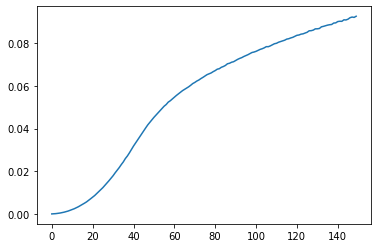

In [34]:
import matplotlib.pyplot as plt
plt.plot(data["mutual_info"].reset_index(drop=True)['word_len 2'])

<AxesSubplot:>

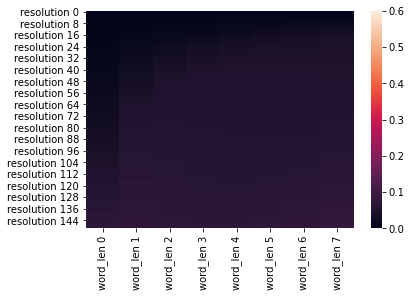

In [34]:
sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.6)

<AxesSubplot:>

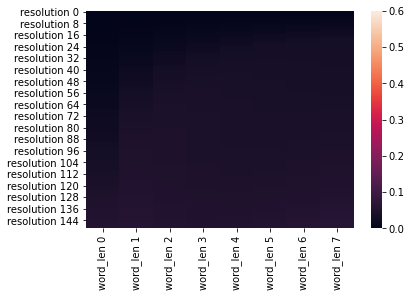

In [35]:
sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.6)

In [18]:
data['transfer_info_col1_col2'].convert_dtypes()

,word_len 0,word_len 1,word_len 2,word_len 3,word_len 4,word_len 5,word_len 6,word_len 7
resolution 0,1.473323e-05,0.000029,0.000044,0.000062,0.000078,0.000096,0.000113,0.000129
resolution 1,3.161382e-05,0.000051,0.000078,0.000101,0.000123,0.000160,0.000196,0.000224
resolution 2,4.953448e-05,0.000075,0.000099,0.000165,0.000210,0.000257,0.000305,0.000357
resolution 3,8.431653e-07,0.000069,0.000097,0.000125,0.000155,0.000187,0.000222,0.000265
resolution 4,5.136340e-06,0.000010,0.000026,0.000036,0.000067,0.000116,0.000177,0.000244
...,...,...,...,...,...,...,...,...
resolution 1995,3.110527e-02,0.098753,0.190291,0.225819,0.255806,0.286521,0.324507,0.369734
resolution 1996,3.156160e-02,0.102045,0.200281,0.234947,0.266264,0.297869,0.336484,0.383125
resolution 1997,3.428090e-02,0.100885,0.195577,0.231660,0.263365,0.294972,0.332963,0.378682
resolution 1998,3.015882e-02,0.099446,0.197203,0.233716,0.265394,0.297279,0.334500,0.377656


In [36]:
df = pd.read_csv("./DatosSinapsisArtificial/TrozoC_bin.csv")[['LP_bin', 'VD_bin']]
df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

In [3]:
df.dtypes

LP_bin    uint8
VD_bin    uint8
dtype: object

In [59]:
with open(data_file, "wb") as f:
    pickle.dump(data, f)

In [60]:
data_file = "dataC.pkl"
try:
    with open(data_file, "rb") as f:
        data = pickle.load(f)
except FileNotFoundError:
    data = np.zeros((14,8))

In [62]:
for i in range(14):
    for j in range(8):
        if data[i][j] != 0:
            print(f"Previamente calculado: resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}], valor={data[i][j]}")
            continue
        print(f"Comienzo cálculo resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}]")
        data[i][j] = mutual_info_optimized(resolution(df, i+1), ['LP_bin', 'VD_bin'], j+1)
        print(f"Calculado: resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}], valor={data[i][j]}")
        with open(data_file, "wb") as f:
            pickle.dump(data, f)

Previamente calculado: resolución=1, ventana=1 en la posicion[0][0], valor=2.0614755821476982e-06
Previamente calculado: resolución=1, ventana=2 en la posicion[0][1], valor=7.4095807517035595e-06
Previamente calculado: resolución=1, ventana=3 en la posicion[0][2], valor=1.7711440774462184e-05
Previamente calculado: resolución=1, ventana=4 en la posicion[0][3], valor=3.1902582232123944e-05
Previamente calculado: resolución=1, ventana=5 en la posicion[0][4], valor=4.955434285208726e-05
Previamente calculado: resolución=1, ventana=6 en la posicion[0][5], valor=7.145569919383976e-05
Previamente calculado: resolución=1, ventana=7 en la posicion[0][6], valor=9.687272837563543e-05
Previamente calculado: resolución=1, ventana=8 en la posicion[0][7], valor=0.00012617250173557748
Previamente calculado: resolución=2, ventana=1 en la posicion[1][0], valor=7.854290998060565e-06
Previamente calculado: resolución=2, ventana=2 en la posicion[1][1], valor=3.114204515242136e-05
Previamente calculado: re

Entropia primera columna: 0.8767567519653664
Entropia segunda columna: 0.6447421538876463
Entropia conjunta: 1.5110776748647492
Calculado: resolución=9, ventana=8 en la posicion[8][7], valor=0.010421230988263641
Comienzo cálculo resolución=10, ventana=1 en la posicion[9][0]
Entropia primera columna: 0.12013238973870273
Entropia segunda columna: 0.08838206651293776
Entropia conjunta: 0.20831357735058048
Calculado: resolución=10, ventana=1 en la posicion[9][0], valor=0.00020087890106001982
Comienzo cálculo resolución=10, ventana=2 en la posicion[9][1]
Entropia primera columna: 0.23989585208493652
Entropia segunda columna: 0.17659437532659064
Entropia conjunta: 0.41573056464054914
Calculado: resolución=10, ventana=2 en la posicion[9][1], valor=0.0007596627709780535
Comienzo cálculo resolución=10, ventana=3 en la posicion[9][2]
Entropia primera columna: 0.3594162910217686
Entropia segunda columna: 0.2646380476959909
Entropia conjunta: 0.6223409349203494
Calculado: resolución=10, ventana=3 

Entropia primera columna: 0.8816903617454656
Entropia segunda columna: 0.6520189389238117
Entropia conjunta: 1.5213662242936805
Calculado: resolución=13, ventana=6 en la posicion[12][5], valor=0.012343076375596729
Comienzo cálculo resolución=13, ventana=7 en la posicion[12][6]
Entropia primera columna: 1.0268690097072544
Entropia segunda columna: 0.7599149071177502
Entropia conjunta: 1.7696563721412826
Calculado: resolución=13, ventana=7 en la posicion[12][6], valor=0.017127544683722018
Comienzo cálculo resolución=13, ventana=8 en la posicion[12][7]
Entropia primera columna: 1.1719491579113732
Entropia segunda columna: 0.8673115563869037
Entropia conjunta: 2.0165881729884094
Calculado: resolución=13, ventana=8 en la posicion[12][7], valor=0.022672541309867622
Comienzo cálculo resolución=14, ventana=1 en la posicion[13][0]
Entropia primera columna: 0.15699870955783224
Entropia segunda columna: 0.11610051595431858
Entropia conjunta: 0.2727379839815017
Calculado: resolución=14, ventana=1 

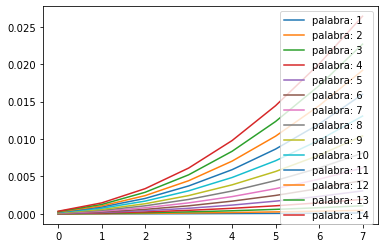

In [63]:
for i in range(14):
    plt.plot(data[i], label=f"resolucion: {i+1}")
    plt.legend()

In [3]:
df = pd.DataFrame(columns=['LP_bin', 'VD_bin'])

In [7]:
df.LP_bin = [0,0,0,0,0,0,0,0,0,0]
df.VD_bin = [0,0,0,0,0,0,0,0,0,0]

In [7]:
mutual_info_optimized(resolution(df, 100), ['LP_bin', 'VD_bin'], 1)

Entropia primera columna: 0.6383522843974425
Entropia segunda columna: 0.5003797555119865
Entropia conjunta: 1.1180052863560763


0.02072675355335285

In [9]:
mutual_info_optimized(resolution(df, 150), ['LP_bin', 'VD_bin'], 1)

Entropia primera columna: 0.7736364504765536
Entropia segunda columna: 0.6185150533286701
Entropia conjunta: 1.348515976071144


0.04363552773407964

In [10]:
df

,Unnamed: 0,LP,VD,LP_bin,VD_bin
0,0,0.004883,0.015259,0,0
1,1,0.001526,0.024109,0,0
2,2,-0.010681,0.031128,0,0
3,3,-0.022278,0.041809,0,0
4,4,-0.028076,0.045471,0,0
...,...,...,...,...,...
19847695,19847695,-0.005798,0.017395,0,0
19847696,19847696,-0.007019,0.024109,0,0
19847697,19847697,-0.000916,0.029602,0,0
19847698,19847698,0.007324,0.039368,0,0


(0.0, 2000.0)

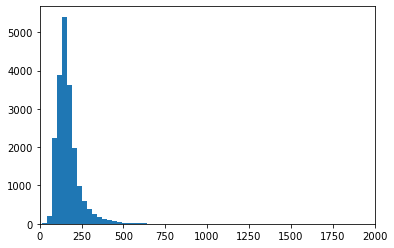

In [37]:
w = df.index[df.VD_bin > 0]
w = w[1:] - w[:-1]
plt.hist(w,bins=1000)
plt.xlim((0, 2000))

In [17]:
w

Int64Index([  97,  111,  130,  133,  135,  125,  156,  147,  132,  186,
            ...
             200,  214,  227,  500, 4951,  111,  154,  171,  178,  359],
           dtype='int64', length=32352)

In [ ]:
w = df.index[df.LP_bin > 0]

In [18]:
pd.Series(w).reindex()

0         97
1        111
2        130
3        133
4        135
        ... 
32347    111
32348    154
32349    171
32350    178
32351    359
Length: 32352, dtype: int64

In [38]:
threshold = 1000
w = df.index[df.LP_bin > 0]
w = (w[1:] - w[:-1]).to_list()
w.insert(0, np.inf)
df["distance"] = 0
df.loc[df.LP_bin > 0, "distance"] = w
df["LP2_bin"] = 0
df.loc[df.distance > threshold, "LP2_bin"] = 1

w = df.index[df.VD_bin > 0]
w = (w[1:] - w[:-1]).to_list()
w.insert(0, np.inf)
df["distance"] = 0
df.loc[df.VD_bin > 0, "distance"] = w
df["VD2_bin"] = 0
df.loc[df.distance > threshold, "VD2_bin"] = 1

In [40]:
df["VD2_bin"].sum()

1960

In [ ]:

df2 = get_bursts(df, 1000, ["LP_bin", "VD_bin"], ["LP_burst", "VD_burst"])


In [27]:
len(df.loc[df.LP_bin > 0, "distance"])

32353

In [32]:
df[df.LP_bin > 0]

,LP_bin,VD_bin,joined,distance
2878,1,0,1000,inf
2975,1,0,1000,97.0
3086,1,0,1000,111.0
3216,1,0,1000,130.0
3349,1,0,1000,133.0
...,...,...,...,...
19843981,1,0,1000,111.0
19844135,1,0,1000,154.0
19844306,1,0,1000,171.0
19844484,1,0,1000,178.0


In [29]:
w

Int64Index([  97,  111,  130,  133,  135,  125,  156,  147,  132,  186,
            ...
             200,  214,  227,  500, 4951,  111,  154,  171,  178,  359],
           dtype='int64', length=32352)

In [15]:
transfer_info(resolution(df,100), ['LP_bin', 'VD_bin'], 4)

Entropia primera columna: 2.02324110933116
Entropia segunda columna: 1.5134710660487392
Entropia conjunta: 3.4481154575867468


([0.043789500610948426, 0.05853875887066326],
 0.08859671779315281,
 [2.02324110933116, 1.5134710660487392],
 3.4481154575867468)

In [11]:
a = [1,2]

In [12]:
reversed(a)

In [13]:
for i in reversed(a):
    print(i)

2
1


In [23]:
a.insert(0,np.inf)

In [24]:
a

[inf, 10000, 1, 2]

In [6]:
col_names = [f"word_len {i}" for i in range(10)]
row_names = [f"resolution {i}" for i in range(10)]
data = {
    "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
    "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
    "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
    "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
    "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
}
data["transfer_info_col1_col2"][:] = 0

In [7]:
data

{'transfer_info_col1_col2':              word_len 0 word_len 1 word_len 2 word_len 3 word_len 4  \
 resolution 0          0          0          0          0          0   
 resolution 1          0          0          0          0          0   
 resolution 2          0          0          0          0          0   
 resolution 3          0          0          0          0          0   
 resolution 4          0          0          0          0          0   
 resolution 5          0          0          0          0          0   
 resolution 6          0          0          0          0          0   
 resolution 7          0          0          0          0          0   
 resolution 8          0          0          0          0          0   
 resolution 9          0          0          0          0          0   
 
              word_len 5 word_len 6 word_len 7 word_len 8 word_len 9  
 resolution 0          0          0          0          0          0  
 resolution 1          0          0  